### Suggest moving to neighbour hex;
The hex score is given by 
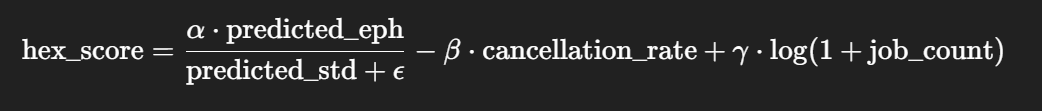

In [9]:
import pandas as pd
import numpy as np
import h3
import folium
from pathlib import Path


project_root = Path.cwd()

data_dir = project_root / "data"


In [10]:
# --- Load CSVs ---
cancellation = pd.read_csv(data_dir/"uber_hackathon_v2_mock_data.xlsx - cancellation_rates.csv")
heatmap = pd.read_csv (data_dir/"uber_hackathon_v2_mock_data.xlsx - heatmap.csv")

# --- Merge on hex id ---
merged = pd.merge(
    cancellation,
    heatmap,
    left_on="hexagon_id9",
    right_on="msg.predictions.hexagon_id_9",
    how="inner"
)

# --- Compute hex score ---
alpha, beta, gamma = 0.3, 0.1, 0.2  # tunable weights
epsilon = 1e-6

merged["hex_score"] = (
    alpha * merged["msg.predictions.predicted_eph"] / (merged["msg.predictions.predicted_std"] + epsilon)
    - beta * merged["cancellation_rate_pct"]
    + gamma * np.log1p(merged["job_count"])
)

# --- Save to CSV ---
output_file = "hex_scores.csv"
merged.to_csv(output_file, index=False)
print(f"✅ Saved merged data with hex_score to {output_file}")


✅ Saved merged data with hex_score to hex_scores.csv


# Call this function when refreshing

In [11]:
# --- Function to recommend better hex in neighbor order (next 18 hexes) ---
def recommend_better_hex_index(current_hex, merged_csv="hex_scores.csv", num_neighbors=18, min_improvement=0.1):
    """
    Returns:
      - relative index of the best hex (0 = current hex, 1..num_neighbors = neighbors)
      - percentage improvement over current hex
    """
    # Load CSV
    merged_df = pd.read_csv(merged_csv)
    
    merged_df["hexagon_id9"] = merged_df["hexagon_id9"].astype(str)
    current_hex = str(current_hex)

    if current_hex not in merged_df["hexagon_id9"].values:
        return None, None  # current hex not found

    # Current hex index and score
    current_idx = merged_df.index[merged_df["hexagon_id9"] == current_hex][0]
    current_score = merged_df.loc[current_idx, "hex_score"]

    # Take next `num_neighbors` as neighbors (mock order)
    neighbors_df = merged_df.iloc[current_idx : current_idx + num_neighbors + 1].copy()
    neighbors_df.reset_index(drop=True, inplace=True)  # 0 = current, 1.. = neighbors

    # Find best scoring hex
    best_idx = neighbors_df["hex_score"].idxmax()
    best_score = neighbors_df.loc[best_idx, "hex_score"]

    # Compute improvement percentage
    if current_score != 0:
        improvement_pct = ((best_score / current_score) - 1) * 100
    else:
        improvement_pct = float('inf') if best_score > 0 else 0

    return best_idx, improvement_pct


In [12]:
merged_csv="hex_scores.csv"
merged_df = pd.read_csv(merged_csv)

example_hex = merged_df["hexagon_id9"].iloc[2]
best_index, improvement = recommend_better_hex_index(example_hex)

print("Relative index of best hex:", best_index)
print(f"Improvement: {improvement:.2f}%")


Relative index of best hex: 14
Improvement: 356.54%
